### Imports

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from IPython import embed
from IPython.display import display, HTML
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from pytorch_cnn import *
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np
import random
import seaborn as sns


### Get data

In [ ]:
# Seed for reproducibility
torch.manual_seed(0)
random.seed(0)

# Set device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get and transform dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)
# Class labels for CIFAR dataset
classes = ('Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified


### Plot some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

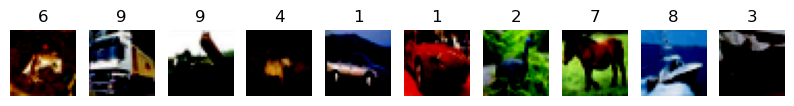

In [3]:
# Get a batch of images and labels
images, labels = next(iter(torch.utils.data.DataLoader(trainset, batch_size=10))) 

# Plot the images with their corresponding labels
fig, axs = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axs):
    #unnormalize before plotting
    image = images[i].numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[i].item()))
    ax.axis('off')

plt.savefig('cifar_img.pdf', bbox_inches='tight')

### Plot 100 images, 10 from every class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

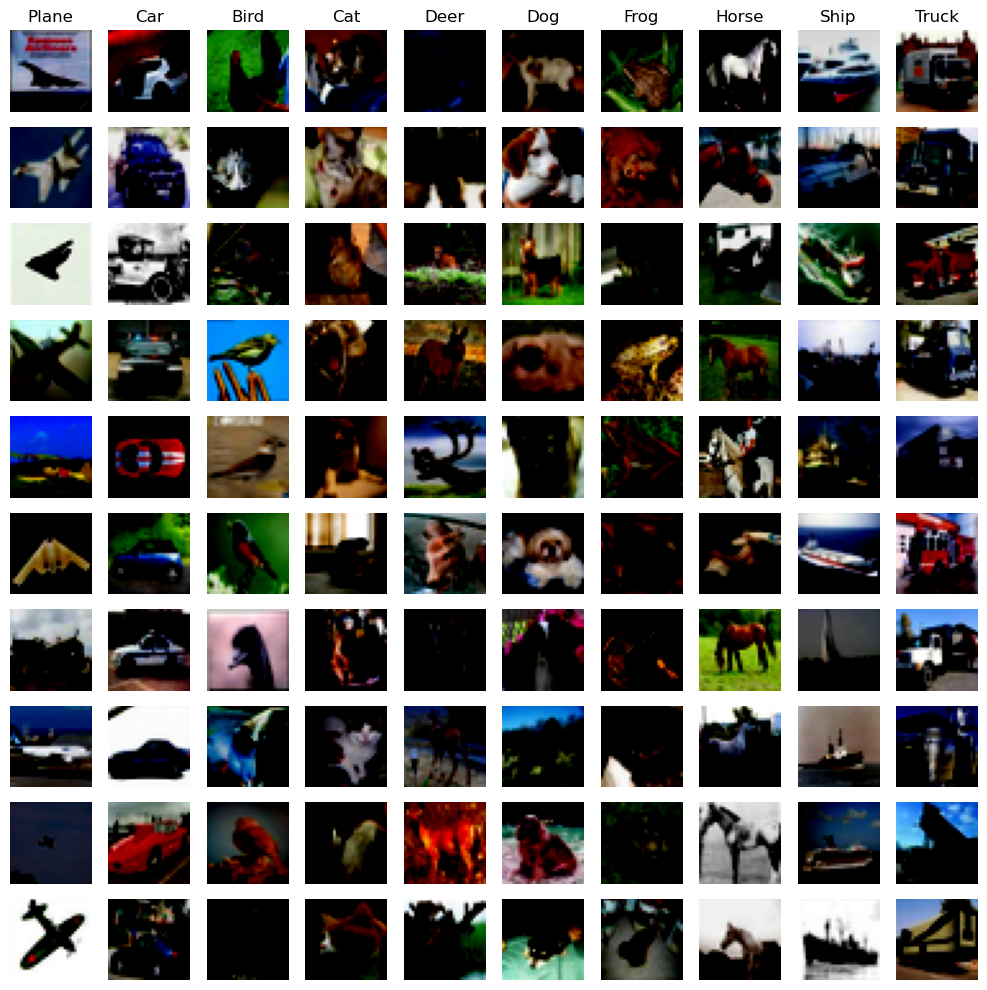

In [4]:
# Plot 100 images
images_by_class = {i: [] for i in range(10)}

for i, (img, label) in enumerate(testset):
    if len(images_by_class[label]) < 10:
        images_by_class[label].append(img)
    if all(len(images) == 10 for images in images_by_class.values()):
        break

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
a=0
for class_label, images in images_by_class.items():   
    for i, img in enumerate(images):
        axes[i, class_label].imshow(img.permute(1, 2, 0))
        axes[i, class_label].axis("off")
    axes[0, class_label].set_title(classes[a])
    a=a+1

plt.tight_layout()
plt.savefig('100_cifar.pdf')


### Plot covariance matrix

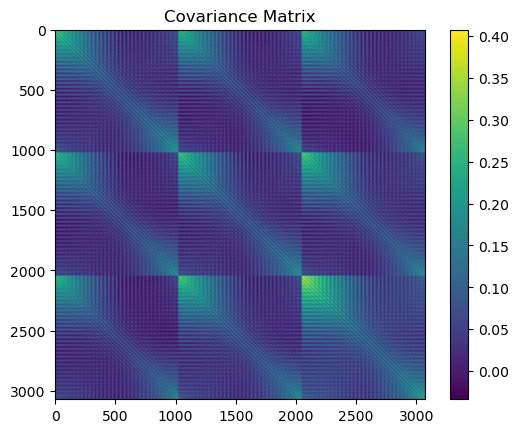

In [10]:
#fig, ax1 = plt.subplots(figsize=(4, 4))
fig1 = plt.figure()
plt.imshow(cov_matrix)

plt.colorbar()
plt.title('Covariance Matrix')
plt.savefig('cov_matrix.pdf')

### FFNN model

In [13]:
# FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
# Initialisze FFNN model
input_size = 32 * 32 * 3  # CIFAR-10 image shape: 32x32x3
hidden_size = 100
num_classes = 10
model_ffnn = FFNN(input_size, hidden_size, num_classes).to(device)

### CNN model

In [8]:
# CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, pooling_size, padding_size, stride, image_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding_size)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pooling_size)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding_size)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pooling_size)

        # Calculate the input of the Linear layer   
        t = time.time()  
        conv1_out = self.get_output_shape(self.maxpool1, self.get_output_shape(self.conv1, image_dim))
        conv2_out = self.get_output_shape(self.maxpool2, self.get_output_shape(self.conv2, conv1_out)) 
        # multiply heigh, weight and channels to get flattened shape
        fc1_in = list(conv2_out)[1]*list(conv2_out)[2]*list(conv2_out)[3]
        self.fc = nn.Linear(fc1_in, 10)
        elapsed = time.time() - t
        #print(f'Time used: {(elapsed):>0.1f}')

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def get_output_shape(self, model, image_dim):
        output_shape = model(torch.rand(*(image_dim))).data.shape
        return output_shape
    
# Initialize CNN model
dimensions = (batch_size, 3,32,32)
model_cnn = CNN(kernel_size = 5, 
            pooling_size = 2, 
            padding_size = 2,
            stride = 1,
            image_dim = dimensions)

### Plot parameter search for ffnn as heatmap

Best parameters: 
 Unnamed: 0         2.000000
Test accuracy     52.620000
Train accuracy    60.584000
Train loss         1.110891
Learning rate      0.000100
Weight decay       0.002683
Epoch             10.000000
Name: 2, dtype: float64


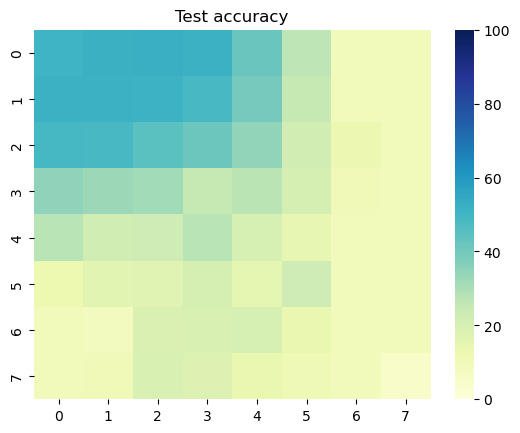

Best parameters: 
 Unnamed: 0         9.000000
Test accuracy     51.740000
Train accuracy    63.830000
Train loss         1.081849
Learning rate      0.000518
Weight decay       0.000518
Epoch             10.000000
Name: 9, dtype: float64


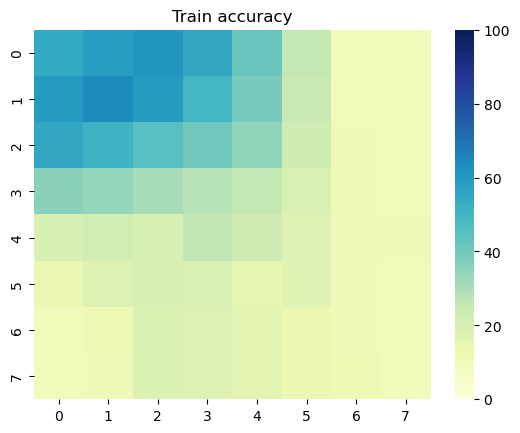

In [150]:
# Open saved data
res = pd.read_csv('results_ffnn.csv')
#res=res[res['Epoch'].values==10]

# plot test accuracy
accuracy_test = [res['Test accuracy']]
best=res['Test accuracy'].idxmax()
print(f'Best parameters: \n {res.loc[best]}')
accuracy_test = np.reshape(accuracy_test,(8,-1))
sns.heatmap(accuracy_test, cmap="YlGnBu", vmin=0, vmax=100)
plt.title('Test accuracy')
plt.show()

# plot train accuracy
accuracy_train = [res['Train accuracy']]
best=res['Train accuracy'].idxmax()
print(f'Best parameters: \n {res.loc[best]}')
accuracy_train = np.reshape(accuracy_train,(8,-1))
sns.heatmap(accuracy_train, cmap="YlGnBu", vmin=0, vmax=100)
plt.title('Train accuracy')
plt.show()

### Plot parameter search for cnn as heatmap

Best parameters: 
 Unnamed: 0        179.000000
Test accuracy      71.920000
Train accuracy     78.984000
Learning rate       0.002683
Weight decay        0.000518
Batch size        200.000000
Epoch              10.000000
Name: 179, dtype: float64


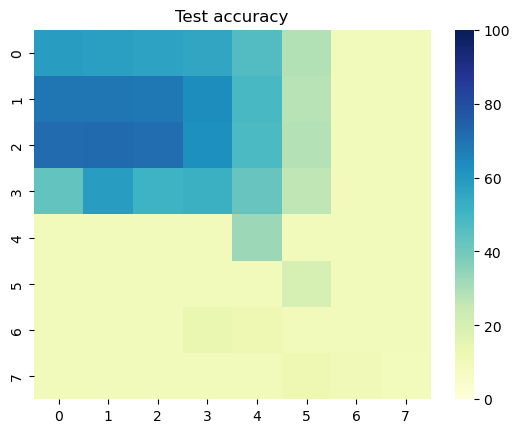

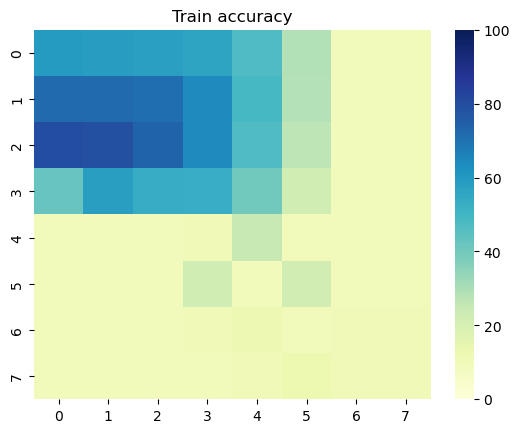

In [151]:
# Open saved data
res = pd.read_csv('results_cnn.csv')
res=res[res['Epoch'].values==10]

# plot test accuracy
accuracy_test = [res['Test accuracy']]
best=res['Test accuracy'].idxmax()
print(f'Best parameters: \n {res.loc[best]}')
accuracy_test = np.reshape(accuracy_test,(8,-1))
sns.heatmap(accuracy_test, cmap="YlGnBu", vmin=0, vmax=100)
plt.title('Test accuracy')
plt.show()

# plot train accuracy
accuracy_train = [res['Train accuracy']]
accuracy_train = np.reshape(accuracy_train,(8,-1))
sns.heatmap(accuracy_train, cmap="YlGnBu", vmin=0, vmax=100)
plt.title('Train accuracy')
plt.show()


### Test loop

In [9]:
# Loop to get predicted values for cnn FIXME: should be changed so same loop can be used for ffnn
def test_loop(dataloader, model, loss_fn, network_type):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    pred_labels = []
    true_labels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            # flatten input if FFNN is used
            if network_type == 'ffnn':
                X = X.reshape(-1, input_size).to(device)
                pred = model_ffnn(X)
            elif network_type == 'cnn':
                pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred_labels.append(pred.argmax(1).numpy())
            true_labels.append(y.numpy())
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")   
    return np.ravel(pred_labels), np.ravel(true_labels)

### Get train and test results

In [14]:
# upload saved model weights and get cnn prediction
model_cnn.load_state_dict(torch.load("cnn_models/epoch_30.pth"))
loss_fn = nn.CrossEntropyLoss()
pred_cnn, true_cnn = test_loop(testloader, model_cnn, loss_fn, 'cnn')
pred_cnn_train, true_cnn_train = test_loop(trainloader, model_cnn, loss_fn, 'cnn')

# upload saved model weights and get cnn prediction
model_ffnn.load_state_dict(torch.load("ffnn_models/epoch_30.pth"))
loss_fn = nn.CrossEntropyLoss()
pred_ffnn, true_ffnn = test_loop(testloader, model_ffnn, loss_fn, 'ffnn')
pred_ffnn_train, true_ffnn_train = test_loop(trainloader, model_ffnn, loss_fn, 'ffnn')

Test Error: 
 Accuracy: 71.0%, Avg loss: 0.896815 

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.491504 

Test Error: 
 Accuracy: 52.0%, Avg loss: 1.374738 

Test Error: 
 Accuracy: 58.9%, Avg loss: 1.220237 



### Make convergence plot

In [51]:
# Function to save accuracies in an array
def get_test_accuracy(epochs, model_type):
    test_acc_array = np.ones(((epochs+1),1))
    for i in range(epochs+1):
        if model_type == 'ffnn':
            model_ffnn.load_state_dict(torch.load(f"ffnn_models/epoch_{i}.pth"))
            pred, true = test_loop(testloader, model_ffnn, loss_fn, model_type)
        elif model_type == 'cnn':
            model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{i}.pth"))
            pred, true = test_loop(testloader, model_cnn, loss_fn, model_type)
        test_acc_array[i] = accuracy_score(pred, true)
    return test_acc_array

# Function to save accuracies in an array
def get_train_accuracy(epochs, model_type):
    test_acc_array = np.ones(((epochs+1),1))
    for i in range(epochs+1):
        if model_type == 'ffnn':
            model_ffnn.load_state_dict(torch.load(f"ffnn_models/epoch_{i}.pth"))
            pred, true = test_loop(trainloader, model_ffnn, loss_fn, model_type)
        elif model_type == 'cnn':
            model_cnn.load_state_dict(torch.load(f"cnn_models/epoch_{i}.pth"))
            pred, true = test_loop(trainloader, model_cnn, loss_fn, model_type)
        test_acc_array[i] = accuracy_score(pred, true)
    return test_acc_array

epochs = 30
# get accuracies
test_acc_ffnn = get_test_accuracy(epochs,  'ffnn')
test_acc_cnn = get_test_accuracy(epochs,  'cnn')
train_acc_ffnn = get_train_accuracy(epochs,  'ffnn')
train_acc_cnn = get_train_accuracy(epochs,  'cnn')

# Plot convergence
x_plot = np.arange(epochs+1)
fig, ax = plt.subplots()
ax.plot(x_plot, test_acc_ffnn, 'r', label= 'FFNN test')
ax.plot(x_plot, train_acc_ffnn,'r--', label= 'FFNN train')
ax.plot(x_plot, test_acc_cnn, 'b', label = 'CNN test')
ax.plot(x_plot, train_acc_cnn, 'b--', label = 'CNN test')
ax.set(xlabel='Epochs', ylabel='Accuracy (%)',
       title='Convergence')
ax.legend()
ax.grid()
plt.savefig('convegence.pdf')

Test Error: 
 Accuracy: 9.1%, Avg loss: 2.310570 

Test Error: 
 Accuracy: 40.8%, Avg loss: 1.710963 

Test Error: 
 Accuracy: 44.0%, Avg loss: 1.625066 



KeyboardInterrupt: 

### Plot confusion matrix

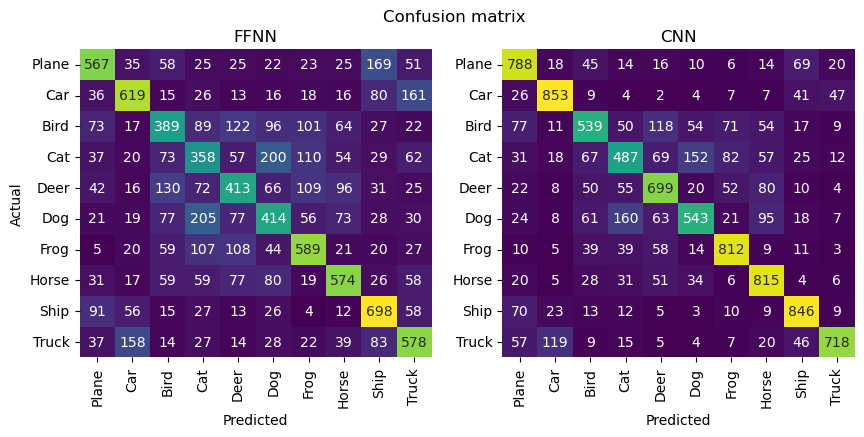

In [15]:
# Calculate the confusion matrices
cm_cnn = confusion_matrix(true_cnn, pred_cnn) # , normalize = 'true')
cm_ffnn = confusion_matrix(true_ffnn, pred_ffnn) #, normalize = 'true')

# Create a heatmap to visualize the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Confusion matrix')
ffnn=sns.heatmap(cm_ffnn, 
                annot=True, 
                fmt="d", 
                cmap="viridis", 
                cbar=False, 
                ax=ax1, 
                xticklabels=classes,
                yticklabels=classes)

cnn=sns.heatmap(cm_cnn, 
                annot=True, 
                fmt="d", 
                cmap="viridis", 
                cbar=False, 
                ax=ax2, 
                xticklabels=classes,
                yticklabels=classes)

cnn.set_xlabel('Predicted')
ffnn.set_xlabel('Predicted')
ffnn.set_ylabel("Actual")
ax1.set_title('FFNN')
ax2.set_title('CNN')
plt.savefig('confusion_matrix.pdf',bbox_inches='tight')

### Make ROC curve with predicted labels

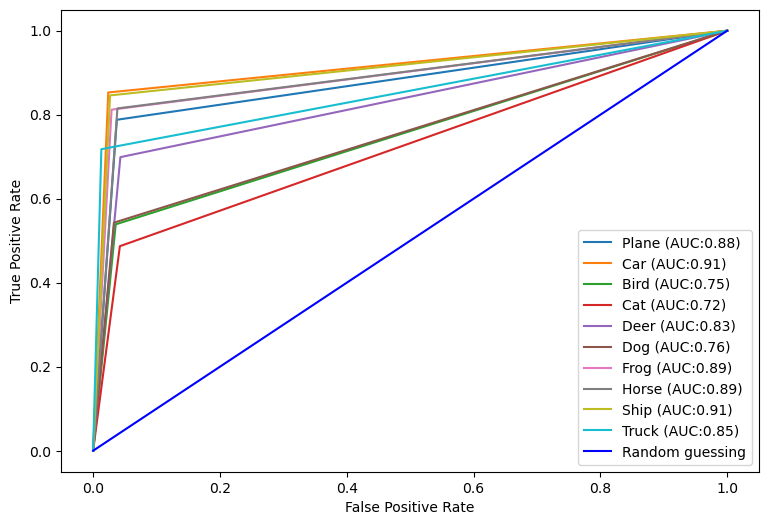

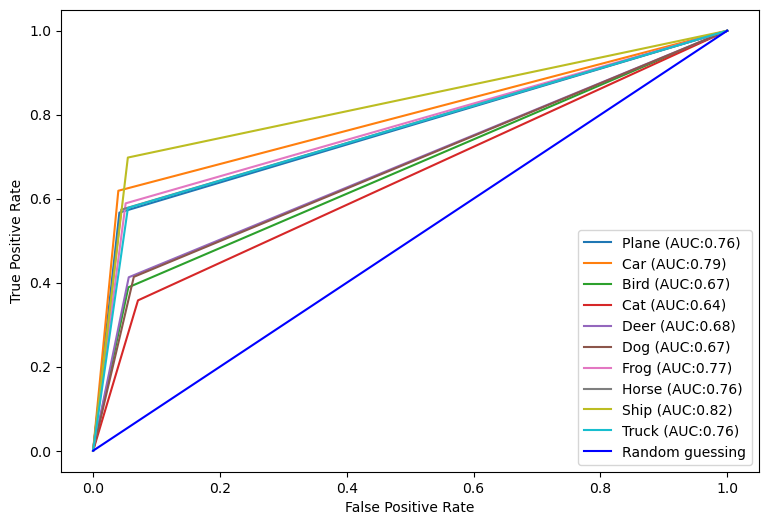

In [15]:
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(classes):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,  label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# plot cnn
fig, c_ax = plt.subplots(1,1, figsize = (9, 6))
fig = multiclass_roc_auc_score(true_cnn, pred_cnn)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('roc_curve.png')

# plot ffnn
fig, c_ax = plt.subplots(1,1, figsize = (9, 6))
fig = multiclass_roc_auc_score(true_ffnn, pred_ffnn)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('roc_curve.png')

### Make ROC plot using the probabilities

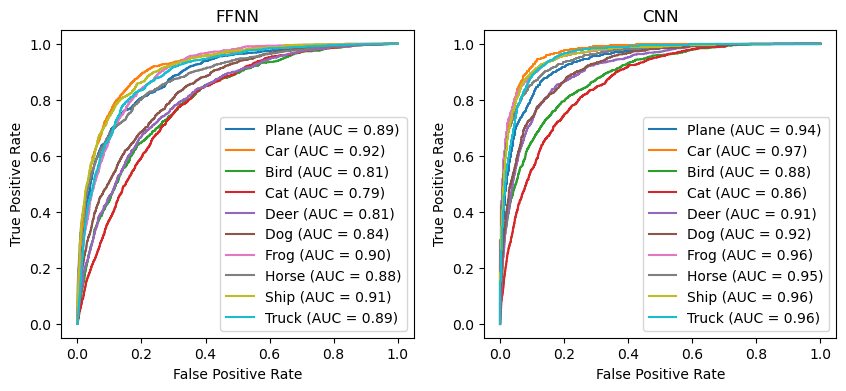

In [10]:
# function that returns the predictions as probabilites and labels as onehot encoded
def test_loop_prob(dataloader, model, loss_fn, network_type):
    model.eval()
    pred_prob = []
    true_labels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            # flatten input if FFNN is used
            if network_type == 'FFNN':
                X = X.reshape(-1, input_size).to(device)
            pred = model(X)
            pred_prob.append(pred.numpy())
            true_labels.append(y.numpy())
    #reshape arrays for later use
    pred=np.array(pred_prob)
    pred=pred.reshape(len(testloader)*batch_size,10)
    true=np.array(true_labels)
    true=true.reshape(len(testloader)*batch_size,1)
    # convert true labels to one-hot
    encoder = OneHotEncoder()
    true = encoder.fit_transform(true)
    true = true.toarray()
    return pred, true

# Initialize CNN model
dimensions = (batch_size, 3,32,32)
model = CNN(kernel_size = 5, 
            pooling_size = 2, 
            padding_size = 2,
            stride = 1,
            image_dim = dimensions)

# upload saved model weights
model.load_state_dict(torch.load("cnn_models/epoch_30.pth"))

loss_fn = nn.CrossEntropyLoss()
pred_cnn_onehot, true_cnn_onehot = test_loop_prob(testloader, model, loss_fn, CNN)

# Initialize FFNN model
input_size = 32 * 32 * 3  # CIFAR-10 image shape: 32x32x3
hidden_size = 100
num_classes = 10
model = FFNN(input_size, hidden_size, num_classes).to(device)

# upload saved model weights
model.load_state_dict(torch.load('ffnn_models/epoch_30.pth'))

loss_fn = nn.CrossEntropyLoss()
pred_ffnn_onehot, true_ffnn_onehot = test_loop_prob(testloader, model, loss_fn, 'FFNN')

# Plot the ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4 ))
#fig.suptitle('ROC curves')

for i, class_ in enumerate(classes):   
    RocCurveDisplay.from_predictions(
        true_cnn_onehot[:, i],
        pred_cnn_onehot[:, i],
        ax=ax2,
        name=f"{class_}",     
    )
    
for i, class_ in enumerate(classes):   
    RocCurveDisplay.from_predictions(
        true_ffnn_onehot[:, i],
        pred_ffnn_onehot[:, i],
        ax=ax1,
        name=f"{class_}",
    )
#plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax2.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax1.set_title('FFNN')
ax2.set_title('CNN')
plt.savefig('roc_prob.pdf')

In [165]:

# FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    
# Model initialization
input_size = 32 * 32 * 3  # CIFAR-10 image shape: 32x32x3
hidden_size = 100
num_classes = 10
model = FFNN(input_size, hidden_size, num_classes).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.002683)

# run script to visualise layer effects
epochs = 30

torch.save(model.state_dict(), f"ffnn_models/epoch_0.pth")

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------") 
    for i, (images, labels) in enumerate(trainloader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_loss = criterion(outputs, labels)
      #  _, predicted = torch.max(outputs.data, 1)

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), f"ffnn_models/epoch_{epoch+1}.pth")



Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

In [10]:

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

pd.set_option('expand_frame_repr', False)

# Calculate precision, recall, accuracy and F1-score for logsitic reg
precision_cnn = precision_score(true_cnn, pred_cnn, average='weighted')
recall_cnn = recall_score(true_cnn, pred_cnn, average='weighted')
f1_cnn = f1_score(true_cnn, pred_cnn, average='weighted')
accuracy_cnn = accuracy_score(true_cnn, pred_cnn)

precision_cnn_train = precision_score(true_cnn_train, pred_cnn_train, average='weighted')
recall_cnn_train = recall_score(true_cnn_train, pred_cnn_train, average='weighted')
f1_cnn_train = f1_score(true_cnn_train, pred_cnn_train, average='weighted')
accuracy_cnn_train = accuracy_score(true_cnn_train, pred_cnn_train)

# Calculate precision, recall, accuracy and F1-score for ffnn
precision_ffnn = precision_score(true_ffnn, pred_ffnn, average='weighted')
recall_ffnn = recall_score(true_ffnn, pred_ffnn, average='weighted')
f1_ffnn = f1_score(true_ffnn, pred_ffnn, average='weighted')
accuracy_ffnn = accuracy_score(true_ffnn, pred_ffnn)

precision_ffnn_train = precision_score(true_ffnn_train, pred_ffnn_train, average='weighted')
recall_ffnn_train = recall_score(true_ffnn_train, pred_ffnn_train, average='weighted')
f1_ffnn_train = f1_score(true_ffnn_train, pred_ffnn_train, average='weighted')
accuracy_ffnn_train = accuracy_score(true_ffnn_train, pred_ffnn_train)

scores = {'Dataset': ['Train','','Test',''],
          '# Samples': [len(true_cnn_train),'',len(true_cnn),''],
          'Model': ['CNN', 'FFNN','CNN', 'FFNN'], 
          'Accuracy':[accuracy_cnn_train, accuracy_ffnn_train, accuracy_cnn, accuracy_ffnn],
          'Precision': [precision_cnn_train, precision_ffnn_train, precision_cnn,precision_ffnn], 
          'Recall': [recall_cnn_train, recall_ffnn_train, recall_cnn, recall_ffnn], 
          'F1 score': [f1_cnn_train, f1_ffnn_train, f1_cnn,f1_ffnn]}
pd.set_option('display.float_format', lambda x: '%.3f' % x)
score_table = pd.DataFrame(data=scores)
table = pretty_print(score_table)

,Dataset,# Samples,Model,Accuracy,Precision,Recall,F1 score
0,Train,50000,CNN,0.832,0.833,0.832,0.829
1,,,FFNN,0.589,0.587,0.589,0.587
2,Test,10000,CNN,0.710,0.708,0.710,0.706
3,,,FFNN,0.520,0.518,0.520,0.518
